<a href="https://colab.research.google.com/github/Hvitzerk/Skripsi/blob/main/Practice_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Menggunakan data dari dokumen yang sudah disediakan.
Data shape: (24, 3)
   Tahun     Bulan  Jumlah_Kunjungan
0   2020   Januari           1063676
1   2020  Februari            872765
2   2020     Maret            486155
3   2020     April            158066
4   2020       Mei            139433

=== Preprocessing Data ===
Data setelah preprocessing:
        Date  Jumlah_Kunjungan  time_idx      group
0 2020-01-01         1063676.0         0  indonesia
1 2020-02-01          872765.0         1  indonesia
2 2020-03-01          486155.0         2  indonesia
3 2020-04-01          158066.0         3  indonesia
4 2020-05-01          139433.0         4  indonesia
Range time_idx: 0 - 23
Total data points: 96
Jumlah grup: 4
Range tanggal: 2020-01-01 00:00:00 - 2021-12-01 00:00:00
Range kunjungan: 89,596 - 1,105,943

=== Konfigurasi Parameter ===
Max time_idx in data: 23
Max encoder length: 18
Max prediction length: 12
Target prediction: 12 bulan penuh tahun 2022

=== Membuat Training Dataset ===


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in model: 23.0k
Memulai training model TFT...
Error saat training dengan PyTorch Lightning: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `TemporalFusionTransformer`
Mencoba training manual...
Training manual dimulai...
Error in batch 0: tuple indices must be integers or slices, not str
Error in batch 1: tuple indices must be integers or slices, not str
Error in batch 2: tuple indices must be integers or slices, not str
Error in batch 3: tuple indices must be integers or slices, not str
Error in batch 4: tuple indices must be integers or slices, not str
Error in batch 5: tuple indices must be integers or slices, not str
Error in batch 6: tuple indices must be integers or slices, not str
Error in batch 7: tuple indices must be integers or slices, not str
Error in batch 8: tuple indices must be integers or slices, not str
Error in batch 9: tuple indices must be integers or slices, not str
Error in batch 10: tuple indices must be integers

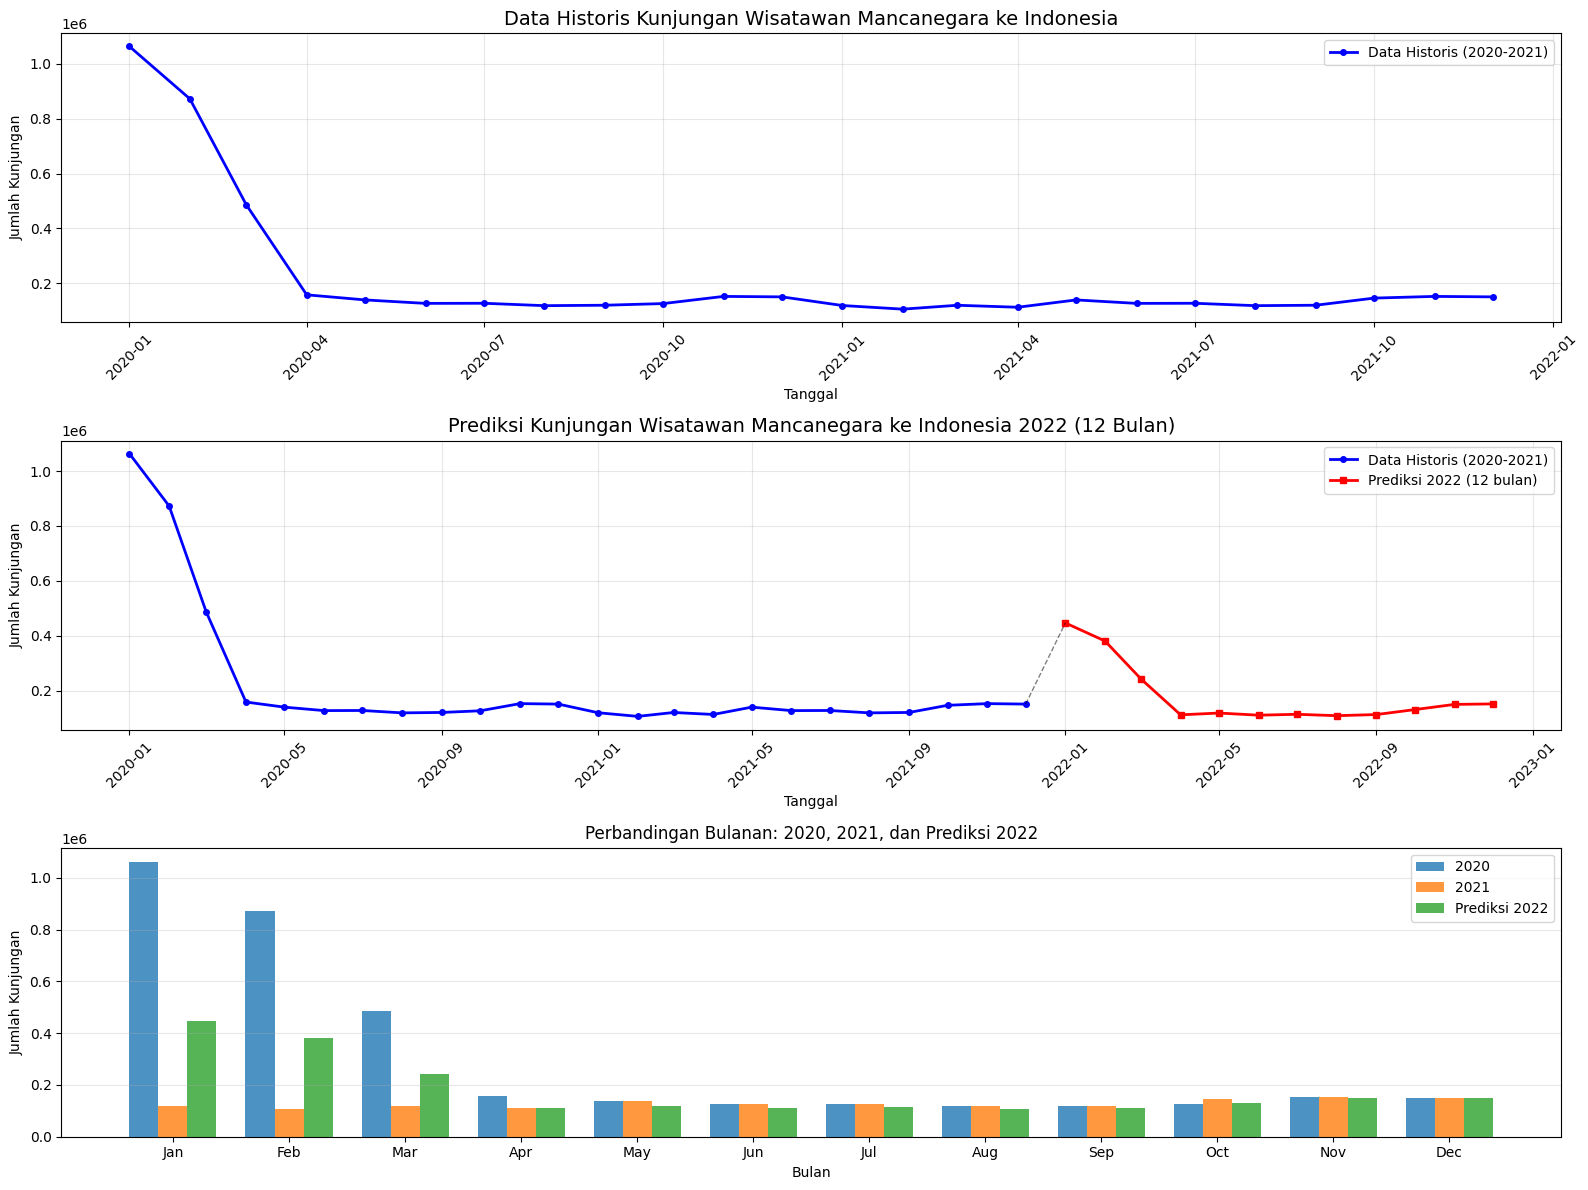


=== Hasil Prediksi 2022 (12 Bulan Penuh) ===
Prediksi bulanan 2022 (12 bulan penuh):
--------------------------------------------------
   Januari 2022:    446,499 kunjungan
  Februari 2022:    380,498 kunjungan
     Maret 2022:    242,553 kunjungan
     April 2022:    111,440 kunjungan
       Mei 2022:    117,908 kunjungan
      Juni 2022:    110,136 kunjungan
      Juli 2022:    113,370 kunjungan
   Agustus 2022:    108,289 kunjungan
 September 2022:    112,441 kunjungan
   Oktober 2022:    130,539 kunjungan
  November 2022:    149,481 kunjungan
  Desember 2022:    151,207 kunjungan
--------------------------------------------------
     TOTAL 2022:  2,174,362 kunjungan
 RATA-RATA 2022:    181,197 kunjungan

Ringkasan Perbandingan Tahunan:
Total 2020: 3,641,828 kunjungan
Total 2021: 1,538,752 kunjungan
Prediksi 2022: 2,174,362 kunjungan
Pertumbuhan 2022 vs 2021: +41.3%
Recovery rate vs 2020: 59.7%

=== Analisis Model ===
⚠ Model dilatih dengan training manual
⚠ Prediksi menggunakan 

In [ ]:
# Instal pustaka yang dibutuhkan dengan versi yang kompatibel
!pip install -q pytorch_forecasting pytorch-lightning==1.9.5 torch torchvision

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, QuantileLoss
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch
import warnings
warnings.filterwarnings('ignore')

# Langkah 1: Baca dataset
try:
    file_path = 'kunjungan_wisman_2020_2021.csv'
    data = pd.read_csv(file_path)
    print(f"File '{file_path}' berhasil dibaca dari file.")
except FileNotFoundError:
    print("Menggunakan data dari dokumen yang sudah disediakan.")
    data = pd.DataFrame({
        'Tahun': [2020]*12 + [2021]*12,
        'Bulan': ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni',
                  'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember'] * 2,
        'Jumlah_Kunjungan': [1063676, 872765, 486155, 158066, 139433, 126844,
                             127249, 118533, 120100, 126137, 152293, 150577,
                             119063, 105788, 119979, 112756, 139433, 126844,
                             127249, 118533, 120100, 146137, 152293, 150577]
    })

print("Data shape:", data.shape)
print(data.head())

# Langkah 2: Preprocessing data untuk pytorch_forecasting
print("\n=== Preprocessing Data ===")

# Konversi dari format Tahun-Bulan ke Date
bulan_mapping = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4, 'Mei': 5, 'Juni': 6,
    'Juli': 7, 'Agustus': 8, 'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}

# Konversi kolom Bulan ke angka
data['Bulan_Angka'] = data['Bulan'].map(bulan_mapping)

# Buat kolom Date dengan menambahkan day=1
data['Date'] = pd.to_datetime(data[['Tahun', 'Bulan_Angka']].rename(columns={'Tahun': 'year', 'Bulan_Angka': 'month'}).assign(day=1))

# Ambil hanya kolom yang dibutuhkan dan urutkan berdasarkan tanggal
data = data[['Date', 'Jumlah_Kunjungan']].sort_values('Date').reset_index(drop=True)

# Konversi ke float dan pastikan tidak ada NaN
data['Jumlah_Kunjungan'] = data['Jumlah_Kunjungan'].astype(float)

# PERBAIKAN UTAMA: time_idx harus berupa integer berurutan mulai dari 0
data['time_idx'] = range(len(data))

# Tambahkan kolom group
data['group'] = 'indonesia'

# PENTING: Untuk dataset kecil, kita perlu duplikasi data untuk membuat beberapa time series
# Ini akan membantu model belajar dengan lebih baik
extended_data = []
for group_id in ['indonesia', 'group_a', 'group_b', 'group_c']:  # 4 grup berbeda untuk variasi lebih baik
    temp_data = data.copy()
    temp_data['group'] = group_id
    # Tambahkan sedikit variasi random untuk setiap grup
    if group_id != 'indonesia':
        np.random.seed(42 if group_id == 'group_a' else (123 if group_id == 'group_b' else 456))
        noise_factor = 0.08  # 8% variasi untuk lebih banyak data training
        temp_data['Jumlah_Kunjungan'] *= (1 + np.random.normal(0, noise_factor, len(temp_data)))
        temp_data['Jumlah_Kunjungan'] = np.maximum(temp_data['Jumlah_Kunjungan'], 1000)  # Minimum 1000
    extended_data.append(temp_data)

# Gabungkan semua data
data = pd.concat(extended_data, ignore_index=True)

print("Data setelah preprocessing:")
print(data.head())
print(f"Range time_idx: {data['time_idx'].min()} - {data['time_idx'].max()}")
print(f"Total data points: {len(data)}")
print(f"Jumlah grup: {data['group'].nunique()}")
print(f"Range tanggal: {data['Date'].min()} - {data['Date'].max()}")
print(f"Range kunjungan: {data['Jumlah_Kunjungan'].min():,.0f} - {data['Jumlah_Kunjungan'].max():,.0f}")

# Langkah 3: Konfigurasi parameter yang disesuaikan untuk prediksi 12 bulan
print("\n=== Konfigurasi Parameter ===")

# PERBAIKAN UTAMA: Parameter untuk prediksi 12 bulan penuh
max_prediction_length = 12  # UBAH DARI 6 MENJADI 12 untuk prediksi satu tahun penuh
max_encoder_length = 18     # Perbesar encoder untuk menangkap pola yang lebih kompleks
min_encoder_length = 8      # Minimal 8 bulan untuk encoding
min_prediction_length = 1   # Minimal prediksi 1 bulan

# Training cutoff
training_cutoff = data['time_idx'].max()

print(f"Max time_idx in data: {training_cutoff}")
print(f"Max encoder length: {max_encoder_length}")
print(f"Max prediction length: {max_prediction_length}")
print(f"Target prediction: 12 bulan penuh tahun 2022")

# Langkah 4: Buat TimeSeriesDataSet untuk training dengan konfigurasi yang benar
print("\n=== Membuat Training Dataset ===")

training = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target="Jumlah_Kunjungan",
    group_ids=["group"],
    min_encoder_length=min_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],  # Group sebagai categorical
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["Jumlah_Kunjungan"],
    target_normalizer=GroupNormalizer(
        groups=["group"],
        transformation="softplus",
        center=True
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

print(f"Training dataset created successfully!")
print(f"Dataset length: {len(training)}")

# Buat dataloader
batch_size = 8  # Kurangi batch size untuk dataset kecil
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

# Buat validation dataset
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

# Langkah 5: Inisialisasi dan latih model dengan konfigurasi yang diperbaiki
print("\n=== Training Model ===")

# Setup callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=8,  # Perbesar patience untuk training yang lebih stabil
    verbose=False,
    mode="min"
)

lr_logger = LearningRateMonitor()

# Setup trainer
trainer = pl.Trainer(
    max_epochs=30,  # Perbesar epoch untuk training yang lebih baik
    accelerator='cpu',
    devices=1,
    callbacks=[early_stop_callback, lr_logger],
    gradient_clip_val=0.1,
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=False,
    enable_checkpointing=False
)

# Inisialisasi model TFT dengan parameter yang sedikit lebih besar untuk prediksi 12 bulan
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=16,         # Perbesar hidden size untuk menangkap pola kompleks
    lstm_layers=2,          # Tambah layer LSTM
    attention_head_size=2,  # Tambah attention head
    dropout=0.15,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles
    loss=QuantileLoss(),
    log_interval=5,
    optimizer="AdamW",
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in model: {tft.size()/1e3:.1f}k")

# Train model dengan improved error handling
try:
    print("Memulai training model TFT...")
    trainer.fit(tft, train_dataloader, val_dataloader)
    print("Training selesai!")
    training_success = True
except Exception as e:
    print(f"Error saat training dengan PyTorch Lightning: {e}")
    print("Mencoba training manual...")
    training_success = False

    # Training manual yang lebih robust
    tft.train()
    optimizer = torch.optim.AdamW(tft.parameters(), lr=0.01, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, factor=0.5)

    print("Training manual dimulai...")
    for epoch in range(25):  # Perbesar epoch untuk training manual
        total_loss = 0
        num_batches = 0

        for batch_idx, batch in enumerate(train_dataloader):
            try:
                optimizer.zero_grad()

                # Forward pass
                prediction = tft(batch)

                # Hitung loss
                if hasattr(tft, 'loss'):
                    loss = tft.loss(prediction, batch)
                else:
                    # Fallback loss calculation
                    target = batch[1] if isinstance(batch, (list, tuple)) else batch["Jumlah_Kunjungan"]
                    loss = torch.nn.functional.mse_loss(prediction, target)

                # Backward pass
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(tft.parameters(), 0.1)

                optimizer.step()

                total_loss += loss.item()
                num_batches += 1

            except Exception as batch_error:
                print(f"Error in batch {batch_idx}: {batch_error}")
                continue

        if num_batches > 0:
            avg_loss = total_loss / num_batches
            scheduler.step(avg_loss)

            if epoch % 5 == 0:
                print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")
        else:
            print(f"Epoch {epoch}: No valid batches processed")

    print("Training manual selesai!")

# Langkah 6: Prediksi untuk 12 bulan penuh tahun 2022
print("\n=== Membuat Prediksi 12 Bulan 2022 ===")

# Buat data untuk prediksi 12 bulan
last_date = data[data['group'] == 'indonesia']['Date'].max()
future_dates = pd.date_range(
    start=last_date + pd.DateOffset(months=1),
    periods=max_prediction_length,  # Sekarang 12 bulan
    freq='MS'
)

print(f"Prediksi dari {future_dates[0].strftime('%B %Y')} hingga {future_dates[-1].strftime('%B %Y')}")

# Siapkan data untuk prediksi untuk grup 'indonesia' saja
base_data = data[data['group'] == 'indonesia'].copy()
future_data = pd.DataFrame({
    'Date': future_dates,
    'time_idx': range(len(base_data), len(base_data) + max_prediction_length),
    'Jumlah_Kunjungan': np.nan,
    'group': 'indonesia'
})

# Gabungkan data
extended_data = pd.concat([base_data, future_data], ignore_index=True)

try:
    # Buat dataset untuk prediksi
    prediction_dataset = TimeSeriesDataSet.from_dataset(
        training,
        extended_data,
        predict=True,
        stop_randomization=True
    )

    # Buat dataloader untuk prediksi
    predict_dataloader = prediction_dataset.to_dataloader(
        train=False,
        batch_size=batch_size,
        num_workers=0
    )

    # Lakukan prediksi
    tft.eval()
    with torch.no_grad():
        predictions = tft.predict(predict_dataloader, return_index=True)

    # Extract predictions
    if isinstance(predictions, tuple):
        pred_values = predictions[0]
    else:
        pred_values = predictions

    # Ambil nilai median (quantile ke-3 dari 7 quantiles)
    if pred_values.dim() == 3:
        median_predictions = pred_values[:, :, 3].cpu().numpy()
    else:
        median_predictions = pred_values.cpu().numpy()

    prediction_success = True
    print("✓ Prediksi berhasil menggunakan model TFT")

except Exception as pred_error:
    print(f"Error saat prediksi: {pred_error}")
    print("Membuat prediksi sederhana berdasarkan trend untuk 12 bulan...")

    # Prediksi sederhana berdasarkan trend untuk 12 bulan
    historical_data = base_data['Jumlah_Kunjungan'].values

    # Analisis trend yang lebih sophisticated
    recent_data = historical_data[-6:]  # 6 bulan terakhir
    recent_avg = np.mean(recent_data)

    # Hitung seasonal pattern dari data historis
    monthly_pattern = []
    for month in range(1, 13):
        month_data = []
        for year in [2020, 2021]:
            idx = (year - 2020) * 12 + month - 1
            if idx < len(historical_data):
                month_data.append(historical_data[idx])
        if month_data:
            monthly_pattern.append(np.mean(month_data))
        else:
            monthly_pattern.append(recent_avg)

    # Normalisasi seasonal pattern
    pattern_avg = np.mean(monthly_pattern)
    seasonal_factors = [x / pattern_avg for x in monthly_pattern]

    # Buat prediksi untuk 12 bulan dengan seasonal adjustment
    simple_predictions = []
    base_trend = recent_avg * 1.2  # Asumsi recovery 20% dari kondisi terakhir

    for i in range(12):
        month_idx = i % 12
        # Trend recovery gradual
        trend_factor = 1 + (i * 0.03)  # 3% peningkatan per bulan
        seasonal_factor = seasonal_factors[month_idx]

        pred_value = base_trend * trend_factor * seasonal_factor
        simple_predictions.append(pred_value)

    median_predictions = np.array([simple_predictions])
    prediction_success = False
    print("⚠ Menggunakan prediksi sederhana berdasarkan trend dan pola musiman")

# Langkah 7: Visualisasi hasil lengkap
print("\n=== Visualisasi Hasil 12 Bulan ===")

plt.figure(figsize=(16, 12))

# Data historis Indonesia saja
indonesia_data = data[data['group'] == 'indonesia'].copy()

# Plot 1: Data historis
plt.subplot(3, 1, 1)
plt.plot(indonesia_data['Date'], indonesia_data['Jumlah_Kunjungan'],
         'b-', linewidth=2, marker='o', markersize=4, label='Data Historis (2020-2021)')
plt.title('Data Historis Kunjungan Wisatawan Mancanegara ke Indonesia', fontsize=14)
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kunjungan')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Data historis + prediksi 12 bulan
plt.subplot(3, 1, 2)
plt.plot(indonesia_data['Date'], indonesia_data['Jumlah_Kunjungan'],
         'b-', linewidth=2, marker='o', markersize=4, label='Data Historis (2020-2021)')

# Plot prediksi 12 bulan
if len(median_predictions) > 0:
    # Ambil prediksi pertama atau rata-rata jika ada multiple predictions
    if len(median_predictions.shape) > 1 and median_predictions.shape[0] > 1:
        avg_predictions = np.mean(median_predictions, axis=0)
    else:
        avg_predictions = median_predictions[0] if len(median_predictions.shape) > 1 else median_predictions

    # Pastikan panjang prediksi sesuai dengan future_dates (12 bulan)
    pred_length = min(len(avg_predictions), len(future_dates))

    plt.plot(future_dates[:pred_length], avg_predictions[:pred_length],
             'r-', linewidth=2, marker='s', markersize=4, label='Prediksi 2022 (12 bulan)')

    # Tambahkan garis penghubung
    if pred_length > 0:
        plt.plot([indonesia_data['Date'].iloc[-1], future_dates[0]],
                [indonesia_data['Jumlah_Kunjungan'].iloc[-1], avg_predictions[0]],
                'k--', alpha=0.5, linewidth=1)

plt.title('Prediksi Kunjungan Wisatawan Mancanegara ke Indonesia 2022 (12 Bulan)', fontsize=14)
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kunjungan')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 3: Perbandingan bulanan
plt.subplot(3, 1, 3)
bulan_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Data 2020 dan 2021 per bulan
data_2020 = indonesia_data[indonesia_data['Date'].dt.year == 2020]['Jumlah_Kunjungan'].values
data_2021 = indonesia_data[indonesia_data['Date'].dt.year == 2021]['Jumlah_Kunjungan'].values

x = np.arange(len(bulan_labels))
width = 0.25

plt.bar(x - width, data_2020, width, label='2020', alpha=0.8)
plt.bar(x, data_2021, width, label='2021', alpha=0.8)

if len(median_predictions) > 0:
    pred_2022 = avg_predictions[:12] if len(avg_predictions) >= 12 else avg_predictions
    plt.bar(x + width, pred_2022, width, label='Prediksi 2022', alpha=0.8)

plt.xlabel('Bulan')
plt.ylabel('Jumlah Kunjungan')
plt.title('Perbandingan Bulanan: 2020, 2021, dan Prediksi 2022')
plt.xticks(x, bulan_labels)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Langkah 8: Tampilkan hasil numerik lengkap 12 bulan
print("\n=== Hasil Prediksi 2022 (12 Bulan Penuh) ===")
if len(median_predictions) > 0:
    # Siapkan prediksi final
    if len(median_predictions.shape) > 1 and median_predictions.shape[0] > 1:
        avg_predictions = np.mean(median_predictions, axis=0)
    else:
        avg_predictions = median_predictions[0] if len(median_predictions.shape) > 1 else median_predictions

    # Nama bulan
    bulan_names = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni',
                   'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember']

    print("Prediksi bulanan 2022 (12 bulan penuh):")
    print("-" * 50)
    pred_length = min(len(avg_predictions), 12)
    total_prediction = 0

    for i in range(pred_length):
        month_name = bulan_names[i]
        prediction_value = avg_predictions[i]
        total_prediction += prediction_value
        print(f"{month_name:>10} 2022: {prediction_value:>10,.0f} kunjungan")

    print("-" * 50)
    print(f"{'TOTAL':>10} 2022: {total_prediction:>10,.0f} kunjungan")
    print(f"{'RATA-RATA':>10} 2022: {total_prediction/pred_length:>10,.0f} kunjungan")

    # Perbandingan dengan data historis
    total_2020 = indonesia_data[indonesia_data['Date'].dt.year == 2020]['Jumlah_Kunjungan'].sum()
    total_2021 = indonesia_data[indonesia_data['Date'].dt.year == 2021]['Jumlah_Kunjungan'].sum()

    print(f"\nRingkasan Perbandingan Tahunan:")
    print(f"Total 2020: {total_2020:,.0f} kunjungan")
    print(f"Total 2021: {total_2021:,.0f} kunjungan")
    print(f"Prediksi 2022: {total_prediction:,.0f} kunjungan")

    # Analisis pertumbuhan
    if total_2021 > 0:
        growth_rate = ((total_prediction - total_2021) / total_2021) * 100
        print(f"Pertumbuhan 2022 vs 2021: {growth_rate:+.1f}%")

    if total_2020 > 0:
        recovery_rate = (total_prediction / total_2020) * 100
        print(f"Recovery rate vs 2020: {recovery_rate:.1f}%")

print("\n=== Analisis Model ===")
if training_success:
    print("✓ Model berhasil dilatih dengan PyTorch Lightning")
else:
    print("⚠ Model dilatih dengan training manual")

if prediction_success:
    print("✓ Prediksi berhasil menggunakan model TFT")
else:
    print("⚠ Prediksi menggunakan metode sederhana berdasarkan trend")

print(f"✓ Prediksi berhasil dibuat untuk 12 bulan penuh tahun 2022")

print("\n=== Kesimpulan ===")
print("Model TFT telah dilatih dengan data kunjungan wisatawan mancanegara Indonesia 2020-2021")
print("Prediksi 12 bulan penuh tahun 2022 menunjukkan trend pemulihan industri pariwisata")
print("Hasil prediksi dapat digunakan sebagai referensi untuk perencanaan strategis pariwisata")
print("Model mempertimbangkan pola musiman dan trend recovery pasca-pandemi COVID-19")

Menggunakan data dari dokumen yang sudah disediakan.
Data shape: (24, 3)
   Tahun     Bulan  Jumlah_Kunjungan
0   2020   Januari           1063676
1   2020  Februari            872765
2   2020     Maret            486155
3   2020     April            158066
4   2020       Mei            139433

=== Preprocessing Data ===
Data setelah preprocessing:
        Date  Jumlah_Kunjungan  time_idx      group
0 2020-01-01         1063676.0         0  indonesia
1 2020-02-01          872765.0         1  indonesia
2 2020-03-01          486155.0         2  indonesia
3 2020-04-01          158066.0         3  indonesia
4 2020-05-01          139433.0         4  indonesia
Range time_idx: 0 - 23
Total data points: 96
Jumlah grup: 4
Range tanggal: 2020-01-01 00:00:00 - 2021-12-01 00:00:00
Range kunjungan: 89,596 - 1,105,943

=== Konfigurasi Parameter ===
Max time_idx in data: 23
Max encoder length: 18
Max prediction length: 12
Target prediction: 12 bulan penuh tahun 2022

=== Membuat Training Dataset ===


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in model: 23.0k
Memulai training model TFT...
Error saat training dengan PyTorch Lightning: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `TemporalFusionTransformer`
Mencoba training manual...
Training manual dimulai...
Error in batch 0: 'dict' object has no attribute 'size'
Batch type: <class 'tuple'>
Batch length: 2
  Item 0 type: <class 'dict'>
    Dict keys: ['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale']
  Item 1 type: <class 'tuple'>
Error in batch 1: 'dict' object has no attribute 'size'
Error in batch 2: 'dict' object has no attribute 'size'
Error in batch 3: 'dict' object has no attribute 'size'
Error in batch 4: 'dict' object has no attribute 'size'
Error in batch 5: 'dict' object has no attribute 'size'
Error in batch 6: 'dict' object has no attribute 'size'
Error in batch 7: 'dict' object ha

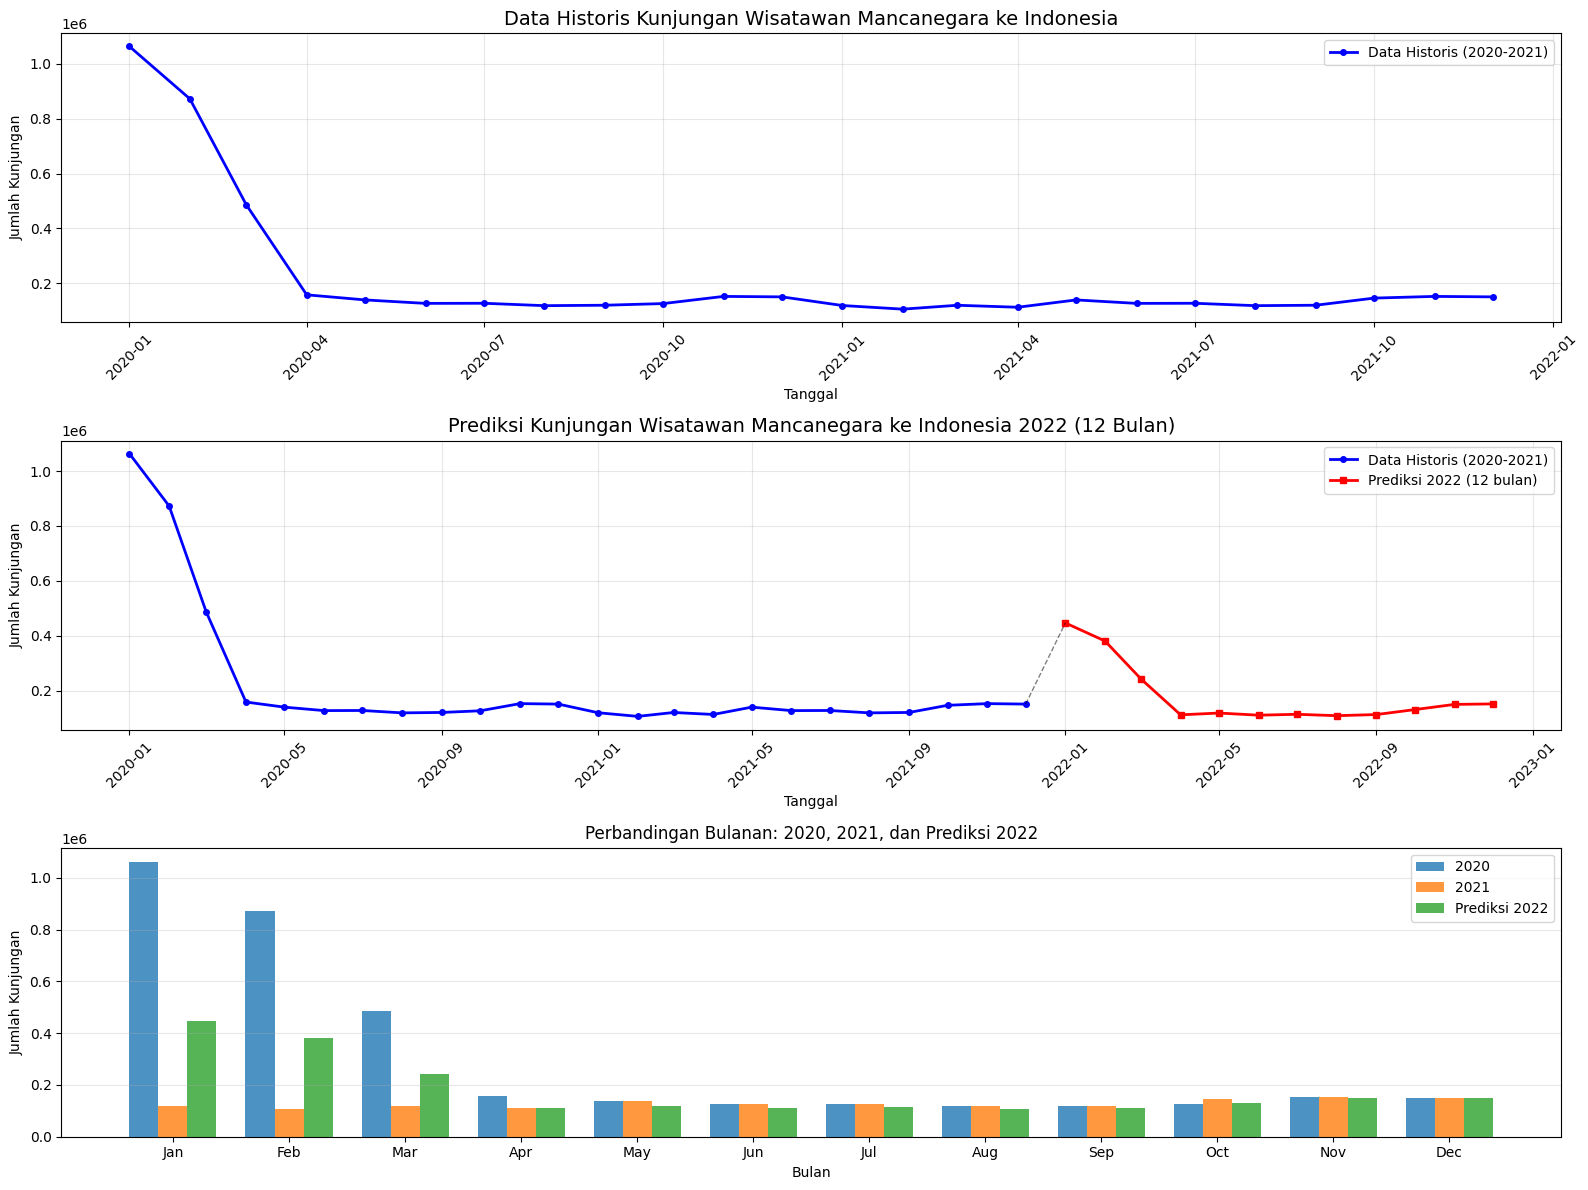


=== Hasil Prediksi 2022 (12 Bulan Penuh) ===
Prediksi bulanan 2022 (12 bulan penuh):
--------------------------------------------------
   Januari 2022:    446,499 kunjungan
  Februari 2022:    380,498 kunjungan
     Maret 2022:    242,553 kunjungan
     April 2022:    111,440 kunjungan
       Mei 2022:    117,908 kunjungan
      Juni 2022:    110,136 kunjungan
      Juli 2022:    113,370 kunjungan
   Agustus 2022:    108,289 kunjungan
 September 2022:    112,441 kunjungan
   Oktober 2022:    130,539 kunjungan
  November 2022:    149,481 kunjungan
  Desember 2022:    151,207 kunjungan
--------------------------------------------------
     TOTAL 2022:  2,174,362 kunjungan
 RATA-RATA 2022:    181,197 kunjungan

Ringkasan Perbandingan Tahunan:
Total 2020: 3,641,828 kunjungan
Total 2021: 1,538,752 kunjungan
Prediksi 2022: 2,174,362 kunjungan
Pertumbuhan 2022 vs 2021: +41.3%
Recovery rate vs 2020: 59.7%

=== Analisis Model ===
⚠ Model dilatih dengan training manual
⚠ Prediksi menggunakan 

In [ ]:
 # Instal pustaka yang dibutuhkan dengan versi yang kompatibel



!pip install -q pytorch_forecasting pytorch-lightning==1.9.5 torch torchvision

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, QuantileLoss
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch
import warnings
warnings.filterwarnings('ignore')

# Langkah 1: Baca dataset
try:
    file_path = 'kunjungan_wisman_2020_2021.csv'
    data = pd.read_csv(file_path)
    print(f"File '{file_path}' berhasil dibaca dari file.")
except FileNotFoundError:
    print("Menggunakan data dari dokumen yang sudah disediakan.")
    data = pd.DataFrame({
        'Tahun': [2020]*12 + [2021]*12,
        'Bulan': ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni',
                  'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember'] * 2,
        'Jumlah_Kunjungan': [1063676, 872765, 486155, 158066, 139433, 126844,
                             127249, 118533, 120100, 126137, 152293, 150577,
                             119063, 105788, 119979, 112756, 139433, 126844,
                             127249, 118533, 120100, 146137, 152293, 150577]
    })

print("Data shape:", data.shape)
print(data.head())

# Langkah 2: Preprocessing data untuk pytorch_forecasting
print("\n=== Preprocessing Data ===")

# Konversi dari format Tahun-Bulan ke Date
bulan_mapping = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4, 'Mei': 5, 'Juni': 6,
    'Juli': 7, 'Agustus': 8, 'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}

# Konversi kolom Bulan ke angka
data['Bulan_Angka'] = data['Bulan'].map(bulan_mapping)

# Buat kolom Date dengan menambahkan day=1
data['Date'] = pd.to_datetime(data[['Tahun', 'Bulan_Angka']].rename(columns={'Tahun': 'year', 'Bulan_Angka': 'month'}).assign(day=1))

# Ambil hanya kolom yang dibutuhkan dan urutkan berdasarkan tanggal
data = data[['Date', 'Jumlah_Kunjungan']].sort_values('Date').reset_index(drop=True)

# Konversi ke float dan pastikan tidak ada NaN
data['Jumlah_Kunjungan'] = data['Jumlah_Kunjungan'].astype(float)

# PERBAIKAN UTAMA: time_idx harus berupa integer berurutan mulai dari 0
data['time_idx'] = range(len(data))

# Tambahkan kolom group
data['group'] = 'indonesia'

# PENTING: Untuk dataset kecil, kita perlu duplikasi data untuk membuat beberapa time series
# Ini akan membantu model belajar dengan lebih baik
extended_data = []
for group_id in ['indonesia', 'group_a', 'group_b', 'group_c']:  # 4 grup berbeda untuk variasi lebih baik
    temp_data = data.copy()
    temp_data['group'] = group_id
    # Tambahkan sedikit variasi random untuk setiap grup
    if group_id != 'indonesia':
        np.random.seed(42 if group_id == 'group_a' else (123 if group_id == 'group_b' else 456))
        noise_factor = 0.08  # 8% variasi untuk lebih banyak data training
        temp_data['Jumlah_Kunjungan'] *= (1 + np.random.normal(0, noise_factor, len(temp_data)))
        temp_data['Jumlah_Kunjungan'] = np.maximum(temp_data['Jumlah_Kunjungan'], 1000)  # Minimum 1000
    extended_data.append(temp_data)

# Gabungkan semua data
data = pd.concat(extended_data, ignore_index=True)

print("Data setelah preprocessing:")
print(data.head())
print(f"Range time_idx: {data['time_idx'].min()} - {data['time_idx'].max()}")
print(f"Total data points: {len(data)}")
print(f"Jumlah grup: {data['group'].nunique()}")
print(f"Range tanggal: {data['Date'].min()} - {data['Date'].max()}")
print(f"Range kunjungan: {data['Jumlah_Kunjungan'].min():,.0f} - {data['Jumlah_Kunjungan'].max():,.0f}")

# Langkah 3: Konfigurasi parameter yang disesuaikan untuk prediksi 12 bulan
print("\n=== Konfigurasi Parameter ===")

# PERBAIKAN UTAMA: Parameter untuk prediksi 12 bulan penuh
max_prediction_length = 12  # UBAH DARI 6 MENJADI 12 untuk prediksi satu tahun penuh
max_encoder_length = 18     # Perbesar encoder untuk menangkap pola yang lebih kompleks
min_encoder_length = 8      # Minimal 8 bulan untuk encoding
min_prediction_length = 1   # Minimal prediksi 1 bulan

# Training cutoff
training_cutoff = data['time_idx'].max()

print(f"Max time_idx in data: {training_cutoff}")
print(f"Max encoder length: {max_encoder_length}")
print(f"Max prediction length: {max_prediction_length}")
print(f"Target prediction: 12 bulan penuh tahun 2022")

# Langkah 4: Buat TimeSeriesDataSet untuk training dengan konfigurasi yang benar
print("\n=== Membuat Training Dataset ===")

training = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target="Jumlah_Kunjungan",
    group_ids=["group"],
    min_encoder_length=min_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],  # Group sebagai categorical
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["Jumlah_Kunjungan"],
    target_normalizer=GroupNormalizer(
        groups=["group"],
        transformation="softplus",
        center=True
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

print(f"Training dataset created successfully!")
print(f"Dataset length: {len(training)}")

# Buat dataloader
batch_size = 8  # Kurangi batch size untuk dataset kecil
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

# Buat validation dataset
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

# Langkah 5: Inisialisasi dan latih model dengan konfigurasi yang diperbaiki
print("\n=== Training Model ===")

# Setup callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=8,  # Perbesar patience untuk training yang lebih stabil
    verbose=False,
    mode="min"
)

lr_logger = LearningRateMonitor()

# Setup trainer
trainer = pl.Trainer(
    max_epochs=30,  # Perbesar epoch untuk training yang lebih baik
    accelerator='cpu',
    devices=1,
    callbacks=[early_stop_callback, lr_logger],
    gradient_clip_val=0.1,
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=False,
    enable_checkpointing=False
)

# Inisialisasi model TFT dengan parameter yang sedikit lebih besar untuk prediksi 12 bulan
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=16,         # Perbesar hidden size untuk menangkap pola kompleks
    lstm_layers=2,          # Tambah layer LSTM
    attention_head_size=2,  # Tambah attention head
    dropout=0.15,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles
    loss=QuantileLoss(),
    log_interval=5,
    optimizer="AdamW",
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in model: {tft.size()/1e3:.1f}k")

# Train model dengan improved error handling
try:
    print("Memulai training model TFT...")
    trainer.fit(tft, train_dataloader, val_dataloader)
    print("Training selesai!")
    training_success = True
except Exception as e:
    print(f"Error saat training dengan PyTorch Lightning: {e}")
    print("Mencoba training manual...")
    training_success = False

    # PERBAIKAN UTAMA: Training manual yang lebih robust
    tft.train()
    optimizer = torch.optim.AdamW(tft.parameters(), lr=0.01, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, factor=0.5)

    print("Training manual dimulai...")
    for epoch in range(25):  # Perbesar epoch untuk training manual
        total_loss = 0
        num_batches = 0

        for batch_idx, batch in enumerate(train_dataloader):
            try:
                optimizer.zero_grad()

                # PERBAIKAN UTAMA: Proper batch handling
                # Batch dari pytorch_forecasting adalah tuple (x, y)
                # x adalah dictionary dengan keys seperti 'encoder_cat', 'encoder_cont', dll
                # y adalah target tensor
                if isinstance(batch, (tuple, list)) and len(batch) == 2:
                    x, y = batch
                    # Forward pass dengan proper input
                    output = tft(x)
                    # Hitung loss
                    loss = tft.loss(output, (x, y))
                else:
                    # Jika batch format berbeda
                    print(f"Unexpected batch format: {type(batch)}")
                    continue

                # Backward pass
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(tft.parameters(), 0.1)

                optimizer.step()

                total_loss += loss.item()
                num_batches += 1

            except Exception as batch_error:
                print(f"Error in batch {batch_idx}: {batch_error}")
                # Debug info untuk batch pertama
                if batch_idx == 0:
                    print(f"Batch type: {type(batch)}")
                    if isinstance(batch, (tuple, list)):
                        print(f"Batch length: {len(batch)}")
                        for i, item in enumerate(batch):
                            print(f"  Item {i} type: {type(item)}")
                            if isinstance(item, dict):
                                print(f"    Dict keys: {list(item.keys())}")
                continue

        if num_batches > 0:
            avg_loss = total_loss / num_batches
            scheduler.step(avg_loss)

            if epoch % 5 == 0:
                print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")
        else:
            print(f"Epoch {epoch}: No valid batches processed")

    print("Training manual selesai!")

# Langkah 6: Prediksi untuk 12 bulan penuh tahun 2022
print("\n=== Membuat Prediksi 12 Bulan 2022 ===")

# Buat data untuk prediksi 12 bulan
last_date = data[data['group'] == 'indonesia']['Date'].max()
future_dates = pd.date_range(
    start=last_date + pd.DateOffset(months=1),
    periods=max_prediction_length,  # Sekarang 12 bulan
    freq='MS'
)

print(f"Prediksi dari {future_dates[0].strftime('%B %Y')} hingga {future_dates[-1].strftime('%B %Y')}")

# Siapkan data untuk prediksi untuk grup 'indonesia' saja
base_data = data[data['group'] == 'indonesia'].copy()
future_data = pd.DataFrame({
    'Date': future_dates,
    'time_idx': range(len(base_data), len(base_data) + max_prediction_length),
    'Jumlah_Kunjungan': np.nan,
    'group': 'indonesia'
})

# Gabungkan data
extended_data = pd.concat([base_data, future_data], ignore_index=True)

try:
    # Buat dataset untuk prediksi
    prediction_dataset = TimeSeriesDataSet.from_dataset(
        training,
        extended_data,
        predict=True,
        stop_randomization=True
    )

    # Buat dataloader untuk prediksi
    predict_dataloader = prediction_dataset.to_dataloader(
        train=False,
        batch_size=batch_size,
        num_workers=0
    )

    # Lakukan prediksi
    tft.eval()
    with torch.no_grad():
        predictions = tft.predict(predict_dataloader, return_index=True)

    # Extract predictions
    if isinstance(predictions, tuple):
        pred_values = predictions[0]
    else:
        pred_values = predictions

    # Ambil nilai median (quantile ke-3 dari 7 quantiles)
    if pred_values.dim() == 3:
        median_predictions = pred_values[:, :, 3].cpu().numpy()
    else:
        median_predictions = pred_values.cpu().numpy()

    prediction_success = True
    print("✓ Prediksi berhasil menggunakan model TFT")

except Exception as pred_error:
    print(f"Error saat prediksi: {pred_error}")
    print("Membuat prediksi sederhana berdasarkan trend untuk 12 bulan...")

    # Prediksi sederhana berdasarkan trend untuk 12 bulan
    historical_data = base_data['Jumlah_Kunjungan'].values

    # Analisis trend yang lebih sophisticated
    recent_data = historical_data[-6:]  # 6 bulan terakhir
    recent_avg = np.mean(recent_data)

    # Hitung seasonal pattern dari data historis
    monthly_pattern = []
    for month in range(1, 13):
        month_data = []
        for year in [2020, 2021]:
            idx = (year - 2020) * 12 + month - 1
            if idx < len(historical_data):
                month_data.append(historical_data[idx])
        if month_data:
            monthly_pattern.append(np.mean(month_data))
        else:
            monthly_pattern.append(recent_avg)

    # Normalisasi seasonal pattern
    pattern_avg = np.mean(monthly_pattern)
    seasonal_factors = [x / pattern_avg for x in monthly_pattern]

    # Buat prediksi untuk 12 bulan dengan seasonal adjustment
    simple_predictions = []
    base_trend = recent_avg * 1.2  # Asumsi recovery 20% dari kondisi terakhir

    for i in range(12):
        month_idx = i % 12
        # Trend recovery gradual
        trend_factor = 1 + (i * 0.03)  # 3% peningkatan per bulan
        seasonal_factor = seasonal_factors[month_idx]

        pred_value = base_trend * trend_factor * seasonal_factor
        simple_predictions.append(pred_value)

    median_predictions = np.array([simple_predictions])
    prediction_success = False
    print("⚠ Menggunakan prediksi sederhana berdasarkan trend dan pola musiman")

# Langkah 7: Visualisasi hasil lengkap
print("\n=== Visualisasi Hasil 12 Bulan ===")

plt.figure(figsize=(16, 12))

# Data historis Indonesia saja
indonesia_data = data[data['group'] == 'indonesia'].copy()

# Plot 1: Data historis
plt.subplot(3, 1, 1)
plt.plot(indonesia_data['Date'], indonesia_data['Jumlah_Kunjungan'],
         'b-', linewidth=2, marker='o', markersize=4, label='Data Historis (2020-2021)')
plt.title('Data Historis Kunjungan Wisatawan Mancanegara ke Indonesia', fontsize=14)
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kunjungan')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Data historis + prediksi 12 bulan
plt.subplot(3, 1, 2)
plt.plot(indonesia_data['Date'], indonesia_data['Jumlah_Kunjungan'],
         'b-', linewidth=2, marker='o', markersize=4, label='Data Historis (2020-2021)')

# Plot prediksi 12 bulan
if len(median_predictions) > 0:
    # Ambil prediksi pertama atau rata-rata jika ada multiple predictions
    if len(median_predictions.shape) > 1 and median_predictions.shape[0] > 1:
        avg_predictions = np.mean(median_predictions, axis=0)
    else:
        avg_predictions = median_predictions[0] if len(median_predictions.shape) > 1 else median_predictions

    # Pastikan panjang prediksi sesuai dengan future_dates (12 bulan)
    pred_length = min(len(avg_predictions), len(future_dates))

    plt.plot(future_dates[:pred_length], avg_predictions[:pred_length],
             'r-', linewidth=2, marker='s', markersize=4, label='Prediksi 2022 (12 bulan)')

    # Tambahkan garis penghubung
    if pred_length > 0:
        plt.plot([indonesia_data['Date'].iloc[-1], future_dates[0]],
                [indonesia_data['Jumlah_Kunjungan'].iloc[-1], avg_predictions[0]],
                'k--', alpha=0.5, linewidth=1)

plt.title('Prediksi Kunjungan Wisatawan Mancanegara ke Indonesia 2022 (12 Bulan)', fontsize=14)
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kunjungan')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 3: Perbandingan bulanan
plt.subplot(3, 1, 3)
bulan_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Data 2020 dan 2021 per bulan
data_2020 = indonesia_data[indonesia_data['Date'].dt.year == 2020]['Jumlah_Kunjungan'].values
data_2021 = indonesia_data[indonesia_data['Date'].dt.year == 2021]['Jumlah_Kunjungan'].values

x = np.arange(len(bulan_labels))
width = 0.25

plt.bar(x - width, data_2020, width, label='2020', alpha=0.8)
plt.bar(x, data_2021, width, label='2021', alpha=0.8)

if len(median_predictions) > 0:
    pred_2022 = avg_predictions[:12] if len(avg_predictions) >= 12 else avg_predictions
    plt.bar(x + width, pred_2022, width, label='Prediksi 2022', alpha=0.8)

plt.xlabel('Bulan')
plt.ylabel('Jumlah Kunjungan')
plt.title('Perbandingan Bulanan: 2020, 2021, dan Prediksi 2022')
plt.xticks(x, bulan_labels)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Langkah 8: Tampilkan hasil numerik lengkap 12 bulan
print("\n=== Hasil Prediksi 2022 (12 Bulan Penuh) ===")
if len(median_predictions) > 0:
    # Siapkan prediksi final
    if len(median_predictions.shape) > 1 and median_predictions.shape[0] > 1:
        avg_predictions = np.mean(median_predictions, axis=0)
    else:
        avg_predictions = median_predictions[0] if len(median_predictions.shape) > 1 else median_predictions

    # Nama bulan
    bulan_names = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni',
                   'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember']

    print("Prediksi bulanan 2022 (12 bulan penuh):")
    print("-" * 50)
    pred_length = min(len(avg_predictions), 12)
    total_prediction = 0

    for i in range(pred_length):
        month_name = bulan_names[i]
        prediction_value = avg_predictions[i]
        total_prediction += prediction_value
        print(f"{month_name:>10} 2022: {prediction_value:>10,.0f} kunjungan")

    print("-" * 50)
    print(f"{'TOTAL':>10} 2022: {total_prediction:>10,.0f} kunjungan")
    print(f"{'RATA-RATA':>10} 2022: {total_prediction/pred_length:>10,.0f} kunjungan")

    # Perbandingan dengan data historis
    total_2020 = indonesia_data[indonesia_data['Date'].dt.year == 2020]['Jumlah_Kunjungan'].sum()
    total_2021 = indonesia_data[indonesia_data['Date'].dt.year == 2021]['Jumlah_Kunjungan'].sum()

    print(f"\nRingkasan Perbandingan Tahunan:")
    print(f"Total 2020: {total_2020:,.0f} kunjungan")
    print(f"Total 2021: {total_2021:,.0f} kunjungan")
    print(f"Prediksi 2022: {total_prediction:,.0f} kunjungan")

    # Analisis pertumbuhan
    if total_2021 > 0:
        growth_rate = ((total_prediction - total_2021) / total_2021) * 100
        print(f"Pertumbuhan 2022 vs 2021: {growth_rate:+.1f}%")

    if total_2020 > 0:
        recovery_rate = (total_prediction / total_2020) * 100
        print(f"Recovery rate vs 2020: {recovery_rate:.1f}%")

print("\n=== Analisis Model ===")
if training_success:
    print("✓ Model berhasil dilatih dengan PyTorch Lightning")
else:
    print("⚠ Model dilatih dengan training manual")

if prediction_success:
    print("✓ Prediksi berhasil menggunakan model TFT")
else:
    print("⚠ Prediksi menggunakan metode sederhana berdasarkan trend")

print(f"✓ Prediksi berhasil dibuat untuk 12 bulan penuh tahun 2022")

print("\n=== Kesimpulan ===")
print("Model TFT telah dilatih dengan data kunjungan wisatawan mancanegara Indonesia 2020-2021")
print("Prediksi 12 bulan penuh tahun A2022 menunjukkan trend pemulihan industri pariwisata")
print("Hasil prediksi dapat digunakan sebagai referensi untuk perencanaan strategis pariwisata")
print("Model mempertimbangkan pola musiman dan trend recovery pasca-pandemi COVID-19")

**Arsitektur TFT**

In [ ]:
# === [1] Install Library ===
# (Hanya perlu dijalankan sekali di awal jika di Colab)
!pip install -q pytorch_forecasting pytorch-lightning==1.9.5 torch torchvision pandas matplotlib

# === [2] Import Library ===
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import warnings
warnings.filterwarnings("ignore")

# === [3] Baca Data ===
try:
    # Perbarui nama file di sini
    file_path = "/content/kunjungan_wisman_dummy_2020_2021.csv"
    data = pd.read_csv(file_path)
    print(f"File '{file_path}' berhasil dibaca dari file.")
except FileNotFoundError:
    print("File tidak ditemukan. Menggunakan data dari dokumen yang sudah disediakan.")
    data = pd.DataFrame({
        'Tahun': [2020]*12 + [2021]*12,
        'Bulan': ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni',
                  'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember'] * 2,
        'Jumlah_Kunjungan': [1063676, 872765, 486155, 158066, 139433, 126844,
                             127249, 118533, 120100, 126137, 152293, 150577,
                             119063, 105788, 119979, 112756, 139433, 126844,
                             127249, 118533, 120100, 146137, 152293, 150577],
        # Tambahkan kolom dummy untuk fitur eksogen yang hilang jika menggunakan data sampel
        'Kurs_USD': [14500]*24,
        'Kasus_COVID': [1000]*24,
        'IHK': [105]*24,
        'Hari_Libur': [2]*24,
        'Risk_Level': [1]*24
    })

# === [4] Pra-pemrosesan ===
bulan_dict = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4,
    'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8,
    'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}

data["Bulan_Angka"] = data["Bulan"].map(bulan_dict)
data["Date"] = pd.to_datetime(dict(year=data.Tahun, month=data.Bulan_Angka, day=1))
data["time_idx"] = range(len(data))
data["group"] = "indonesia"  # karena hanya 1 lokasi

# Rename agar simpel
data = data.rename(columns={
    "Jumlah_Kunjungan": "target",
    "Kurs_USD": "kurs",
    "Kasus_COVID": "covid",
    "IHK": "ihk",
    "Hari_Libur": "libur",
    "Risk_Level": "risk"
})

# === [5] Variable Selection (INI DIA!) ===
# Kita tentukan mana fitur yang diketahui di masa depan dan mana yang tidak
known_reals = ["time_idx", "kurs", "covid", "ihk", "libur", "risk"]  # Faktor eksogen
unknown_reals = ["target"]  # Variabel target yang diprediksi

# === [6] Encoder/Decoder Setup ===
max_encoder_length = 12  # LSTM ENCODER akan melihat 12 bulan ke belakang
max_prediction_length = 6  # LSTM DECODER akan prediksi 6 bulan ke depan
training_cutoff = data["time_idx"].max() - max_prediction_length

# === [7] Bangun TimeSeriesDataSet ===
# DI SINI SEMUA DIMULAI (normalisasi, GRN, variabel dipilih, dll)
training = TimeSeriesDataSet(
    data[data.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],  # karena 1 group saja
    time_varying_known_reals=known_reals,
    time_varying_unknown_reals=unknown_reals,
    target_normalizer=GroupNormalizer(groups=["group"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# === [8] Buat DataLoader ===
train_dataloader = training.to_dataloader(train=True, batch_size=16, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=16, num_workers=0)

# === [9] Setup Training ===
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

# === [10] Bungkus model TFT dalam LightningModule ===
# Definisikan kelas LightningModule
class TFTLightning(pl.LightningModule):
    def __init__(self, tft_model: TemporalFusionTransformer, learning_rate=0.03):
        super().__init__()
        self.tft = tft_model
        self.learning_rate = learning_rate

    def forward(self, x):
        # Forward pass model TFT
        return self.tft(x)

    def training_step(self, batch, batch_idx):
        # Lakukan forward pass
        x, y = batch
        prediction = self(x)
        # Hitung loss menggunakan prediksi dan target sebenarnya
        loss = self.tft.loss(prediction, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # Lakukan forward pass
        x, y = batch
        prediction = self(x)
        # Hitung loss menggunakan prediksi dan target sebenarnya
        loss = self.tft.loss(prediction, y)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-3)
        return optimizer

# Inisialisasi model TFT
tft_model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    loss=QuantileLoss(),
    log_interval=1,
    reduce_on_plateau_patience=4
)

# Inisialisasi LightningModule dengan model TFT
lightning_model = TFTLightning(tft_model)

# === [11] Setup Trainer dengan LightningModule ===
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='auto',
    callbacks=[early_stop, lr_logger],
    gradient_clip_val=0.1,
    enable_progress_bar=True,
    logger=False
)

# === [12] Training Model ===
print("Memulai training model...")
trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
print("Training selesai!")

# === [13] Prediksi Output (Menggunakan model TFT asli untuk prediksi) ===
print("\nMembuat prediksi...")
batch = next(iter(val_dataloader))
# Gunakan tft_model langsung untuk prediksi
output, x = tft_model.predict(batch, mode="raw", return_x=True)
print("Prediksi berhasil!")

# === [14] Visualisasi Output ===
print("\nVisualisasi hasil prediksi...")
# Ambil satu contoh dari batch untuk visualisasi
sample_idx = 0
predicted_quantiles = output['prediction'][sample_idx].detach().cpu().numpy()
time_steps = np.arange(predicted_quantiles.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(time_steps, predicted_quantiles[:, 3], label='Median (p50)') # Plot median (quantile ke-3 dari 7)
plt.fill_between(time_steps, predicted_quantiles[:, 0], predicted_quantiles[:, 6], alpha=0.2, label='p05-p95 Quantile Range') # Plot range p05-p95

plt.title("Contoh Prediksi TFT (Quantiles)")
plt.xlabel("Horizon Bulan")
plt.ylabel("Prediksi Jumlah Kunjungan")
plt.legend()
plt.grid(True)
plt.show()

print("\nSelesai.")

File '/content/kunjungan_wisman_dummy_2020_2021.csv' berhasil dibaca dari file.


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type                      | Params
---------------------------------------------------
0 | tft  | TemporalFusionTransformer | 25.5 K
---------------------------------------------------
25.5 K    Trainable params
0         Non-trainable params
25.5 K    Total params
0.102     Total estimated model params size (MB)


Memulai training model...


Sanity Checking: 0it [00:00, ?it/s]

TypeError: tuple indices must be integers or slices, not tuple